# Cell segmentation C. Elegans

In [185]:
# Importing libraries
import sys
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns
import pandas as pd
import pathlib
import warnings
import re  
from skimage.io import imread
import os; from os import listdir; from os.path import isfile, join
from skimage import io
from cellpose import models
from scipy.ndimage import binary_fill_holes
from skimage.morphology import binary_erosion, disk, square, remove_small_objects
import matplotlib.patches as patches
from scipy.ndimage import binary_dilation
from skimage.measure import label
import cv2
warnings.filterwarnings("ignore")

In [23]:
# Defining directories
current_dir = pathlib.Path().absolute()
fa_dir = current_dir.parents[1].joinpath('src')

# Importing fish_analyses module
sys.path.append(str(fa_dir))
import fish_analyses as fa

In [24]:
directory =current_dir.joinpath('OneDrive_1_6-12-2024','4-cell','all_images')


In [25]:
list_files_names_complete = sorted([f for f in listdir(directory) if isfile(join(directory, f)) and ('.png') in f], key=str.lower)  # reading all tif files in the folder
list_files_names_complete.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order
path_files_complete = [ str(directory.joinpath(f).resolve()) for f in list_files_names_complete ] # creating the complete path for each file
number_files = len(path_files_complete)
list_images_complete = [imread(str(f)) for f in path_files_complete]
print(number_files)
print(list_images_complete[0].shape)

10
(1024, 1024, 4)


In [26]:
path_files_complete

['/Users/luisaguilera/Desktop/FISH_Processing/dev/codes_C_elegans/OneDrive_1_6-12-2024/4-cell/all_images/02_membrane_deconvolved-rep2.png',
 '/Users/luisaguilera/Desktop/FISH_Processing/dev/codes_C_elegans/OneDrive_1_6-12-2024/4-cell/all_images/02_membrane_deconvolved-rep3.png',
 '/Users/luisaguilera/Desktop/FISH_Processing/dev/codes_C_elegans/OneDrive_1_6-12-2024/4-cell/all_images/04_membrane_deconvolved-rep2.png',
 '/Users/luisaguilera/Desktop/FISH_Processing/dev/codes_C_elegans/OneDrive_1_6-12-2024/4-cell/all_images/05_membrane_deconvolved-rep1.png',
 '/Users/luisaguilera/Desktop/FISH_Processing/dev/codes_C_elegans/OneDrive_1_6-12-2024/4-cell/all_images/05_membrane_deconvolved-rep3.png',
 '/Users/luisaguilera/Desktop/FISH_Processing/dev/codes_C_elegans/OneDrive_1_6-12-2024/4-cell/all_images/06_membrane_deconvolved-rep2.png',
 '/Users/luisaguilera/Desktop/FISH_Processing/dev/codes_C_elegans/OneDrive_1_6-12-2024/4-cell/all_images/07_membrane_deconvolved-rep1.png',
 '/Users/luisaguiler

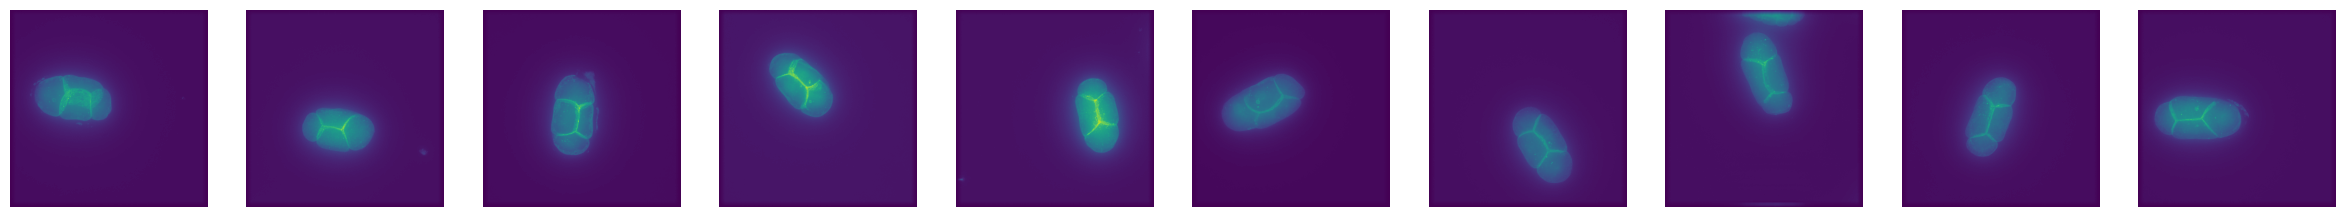

In [27]:
# plotting all list_images_complete, in a subplot with 4 coulmns for each color channel.
fig, axs = plt.subplots(1, number_files, figsize=(30, 10))
for idx_image in range (number_files):
        axs[idx_image].imshow(list_images_complete[idx_image][:,:,0])
        axs[idx_image].axis('off')
plt.show()

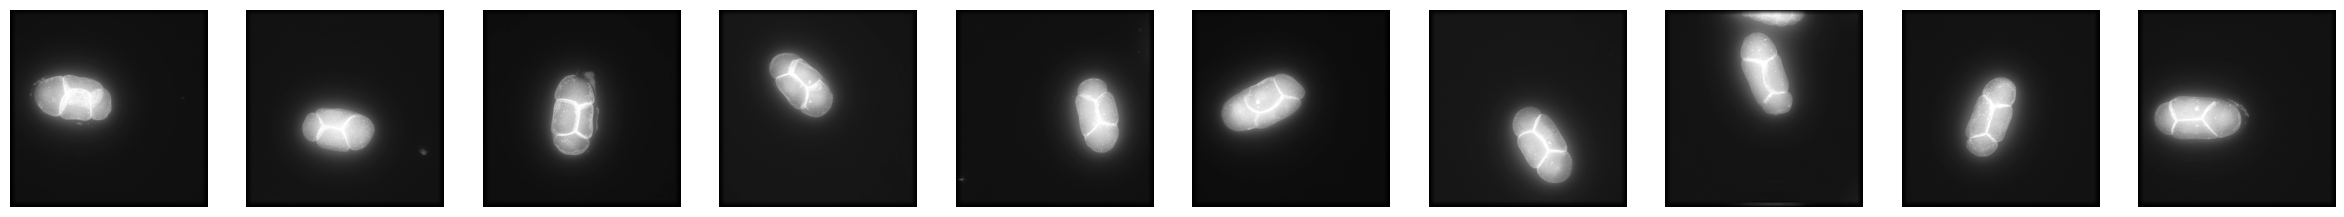

In [28]:
# rescaling images
list_rescaled_images = []
for idx_image in range (number_files):
    list_rescaled_images.append( fa.RemoveExtrema(list_images_complete[idx_image][:,:,0],min_percentile=0, max_percentile=99.8).remove_outliers()  )

# plotting list_rescaled_images as a single row
fig, axs = plt.subplots(1, number_files, figsize=(30, 10))
for idx_image in range (number_files):
    axs[idx_image].imshow(list_rescaled_images[idx_image],cmap='Greys_r')
    axs[idx_image].axis('off')

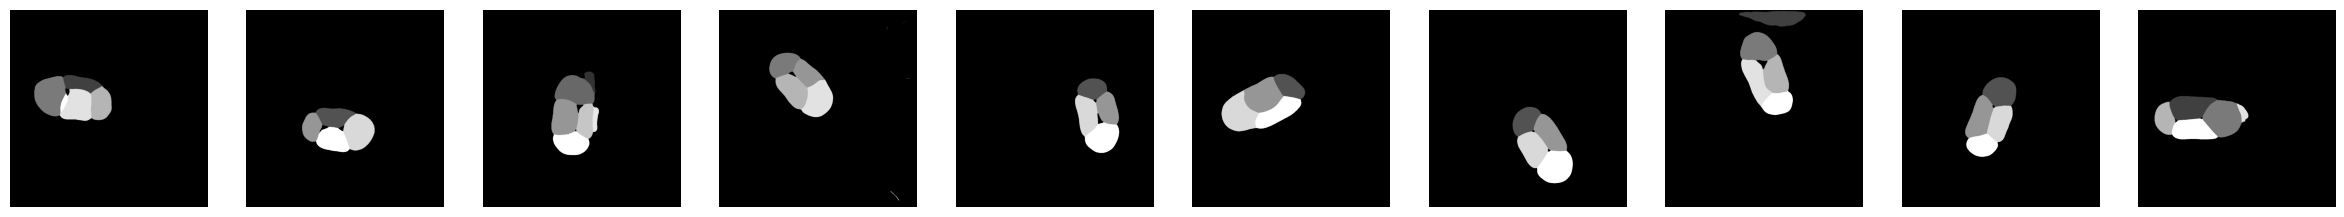

In [141]:
# Cell segmentation
list_masks = []
for i, image in enumerate(list_rescaled_images):
        model = models.Cellpose(gpu=True, model_type='cyto2') # model_type='cyto', 'cyto2' or model_type='nuclei'
        masks = model.eval(image, diameter=100, flow_threshold=1, channels=[0,0], augment=False)[0]
        list_masks.append(masks)

# plotting list_rescaled_images as a single row
fig, axs = plt.subplots(1, number_files, figsize=(30, 10))
for i, image in enumerate(list_masks):
    axs[i].imshow(image,cmap='Greys_r')
    axs[i].axis('off')

In [164]:
def reorder_mask(masks):
    max_original_masks = np.max(masks)
    # Initialize reorder_masks with zeros of the same shape and type as masks_filtered
    reorder_masks = np.zeros(masks.shape, dtype=int)
    # Find the unique labels present in the filtered mask
    unique_filtered = np.unique(masks)
    # Reorder masks
    counter = 1
    for mask_index in range(1, max_original_masks + 1):
        if mask_index in unique_filtered:
            mask_area = masks == mask_index
            reorder_masks[mask_area] = -counter
            counter += 1
    return np.absolute(reorder_masks)

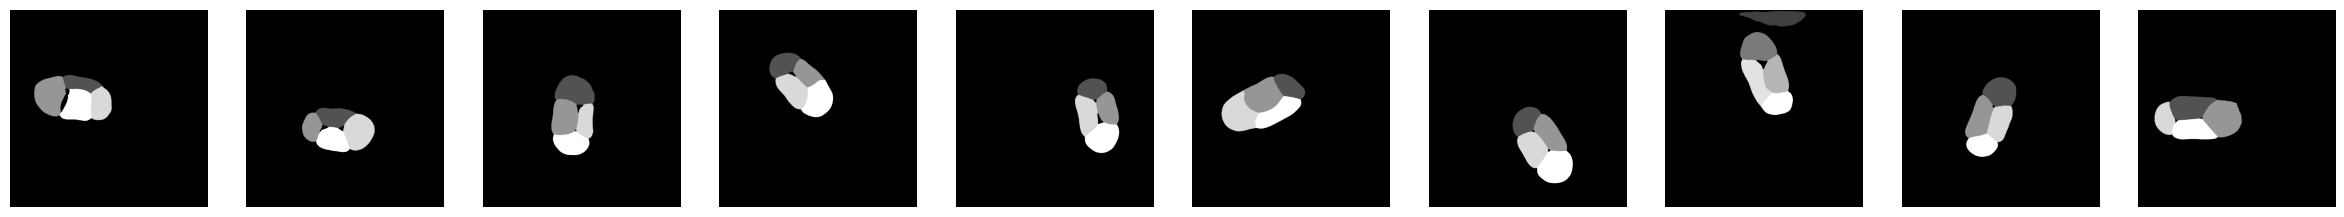

In [165]:
MIN_CELL_SIZE = 5000
list_masks_filtered = []
for i, masks in enumerate(list_masks):
    reorder_masks = np.zeros(masks.shape, dtype=int)
    masks_filtered = remove_small_objects(masks, min_size=MIN_CELL_SIZE, connectivity=1)    
    reorder_masks= reorder_mask(masks_filtered)
    list_masks_filtered.append(np.absolute(reorder_masks))
# Plotting the results
fig, axs = plt.subplots(1, len(list_masks_filtered), figsize=(30, 10))
for i, mask in enumerate(list_masks_filtered):
    axs[i].imshow(mask, cmap='Greys_r')
    axs[i].axis('off')
plt.show()


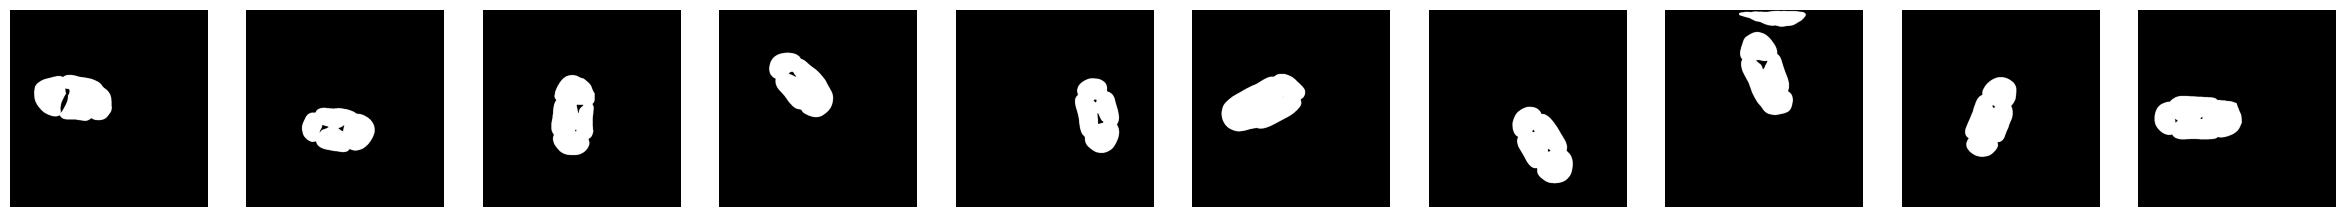

In [111]:
# create a mask for all non-zero elements in the list_masks_filtered
list_masks_all_embryo = []
mask_all = np.zeros(list_masks_filtered[0].shape)
for i, mask in enumerate(list_masks_filtered):
    list_masks_all_embryo.append( np.where(mask > 0, 1, mask_all) )    
    
# plotting list_rescaled_images as a single row
fig, axs = plt.subplots(1, number_files, figsize=(30, 10))
for i, masks in enumerate(list_masks_all_embryo):
    axs[i].imshow(masks,cmap='Greys_r')
    axs[i].axis('off')

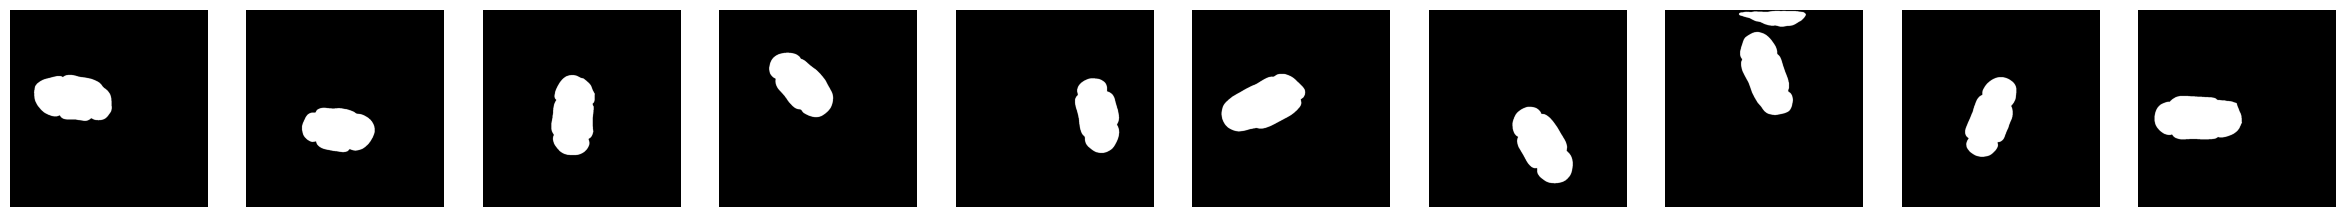

In [112]:
# fill empty spaces in the mask
list_masks_filled = []
for i, mask in enumerate(list_masks_all_embryo):
    list_masks_filled.append( binary_fill_holes(mask) )
# plotting list_rescaled_images as a single row
fig, axs = plt.subplots(1, number_files, figsize=(30, 10))
for i, masks in enumerate(list_masks_filled):
    axs[i].imshow(masks,cmap='Greys_r')
    axs[i].axis('off')

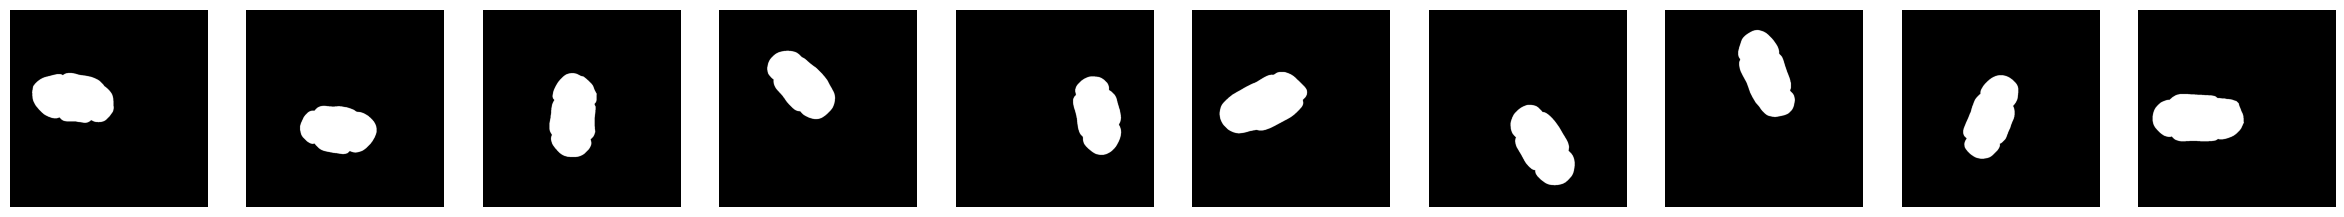

In [135]:
# expand the mask by dilating it and removing the smallest object
list_masks_dilated = []
NUM_PIXELS_TO_DILATE = 10
for i, mask in enumerate(list_masks_filled):
    dilated_mask = binary_dilation(mask, iterations=NUM_PIXELS_TO_DILATE)
    # eliminate smallest disconnected mask by replacing smallest mask with zeros
    label_image = label(dilated_mask)
    if np.max(label_image) > 1:
        # count the number of pixels in each mask that are not zeros
        non_zero_sizes = [np.count_nonzero(label_image == i) for i in range(1, np.max(label_image)+1)] 
        dilated_mask = np.where(label_image == np.argmax(non_zero_sizes)+1, 1, 0)
    list_masks_dilated.append( dilated_mask)
# plotting list_rescaled_images as a single row
fig, axs = plt.subplots(1, number_files, figsize=(30, 10))
for i, masks in enumerate(list_masks_dilated):
    axs[i].imshow(masks,cmap='Greys_r')
    axs[i].axis('off')

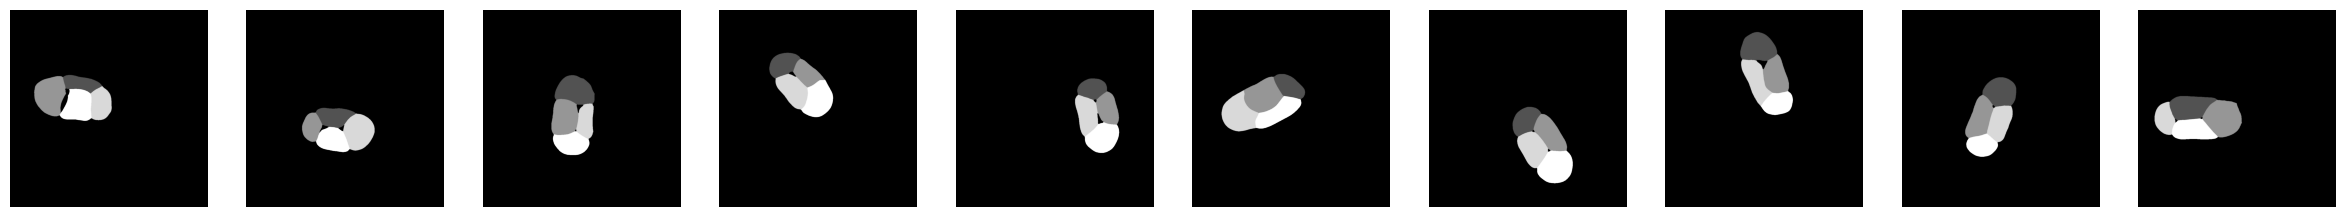

In [166]:
# Removing masks from list_masks_filtered that are not located partially inside list_masks_dilated and reorder the masks
list_masks_filtered_final = []
for i, mask in enumerate(list_masks_filtered):
    # Initialize the final mask with zeros
    mask_filtered_final = np.zeros(mask.shape, dtype=int)
    # Check for non-zero overlap between the filtered mask and the dilated mask
    overlap = np.logical_and(mask > 0, list_masks_dilated[i] > 0)
    if np.any(overlap):
        # Where there's overlap, set the corresponding pixels in the new mask
        mask_filtered_final[overlap] = mask[overlap]
    mask_filtered_final= reorder_mask(mask_filtered_final)
    list_masks_filtered_final.append(mask_filtered_final)
    
# Plotting results for visual inspection
fig, axs = plt.subplots(1, len(list_masks_filtered_final), figsize=(30, 10))
for i, mask_final in enumerate(list_masks_filtered_final):
    axs[i].imshow(mask_final, cmap='Greys_r')
    axs[i].axis('off')
plt.show()



In [199]:
def generate_border_mask(original_mask, n=10):
    final_mask = np.zeros(original_mask.shape, dtype=int)
    num_masks = np.max(original_mask)   
    for i in range(1,num_masks+1):
        selected_cel = original_mask == i
        # Erode the original mask by n pixels
        selem = disk(n)
        eroded_mask = binary_erosion(selected_cel, selem)
        # Create the final mask by subtracting the eroded mask from the original
        final_mask_temp = original_mask - eroded_mask
        # add final_mask to the final_mask
        final_mask = final_mask + final_mask_temp
    return final_mask

[ 0  3  4  7  8 11 12 15 16]


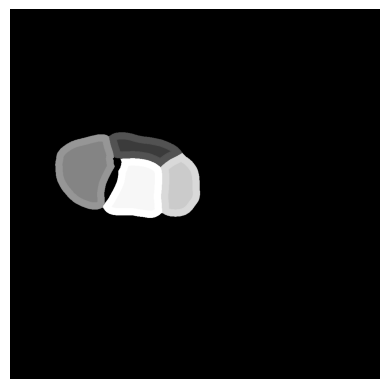

In [200]:
sel_mask = list_masks_filtered_final[0]

# Generate a donut mask for 100 pixels inside test_mask
donut = generate_border_mask(sel_mask.astype(np.uint8), 20)
print(np.unique(donut))
# Plot the donut mask
plt.imshow(donut,cmap='Greys_r')
plt.axis('off')
plt.show()

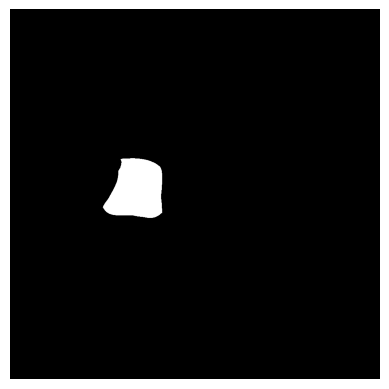

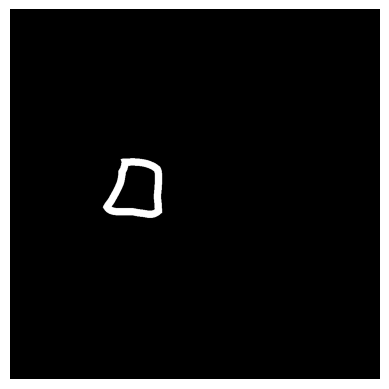

In [187]:
test_mask = list_masks_filtered_final[0]==4
plt.imshow(list_masks_filtered_final[0]==4, cmap='Greys_r')
plt.axis('off')
plt.show()

def generate_border_mask(original_mask, n):
    # Erode the original mask by n pixels
    if n > 0:
        # Create a structural element that defines the erosion size, using disk shape for smooth edges
        selem = disk(n)
        eroded_mask = binary_erosion(original_mask, selem)
    else:
        eroded_mask = original_mask.copy()
    # Create the final mask by subtracting the eroded mask from the original
    final_mask = original_mask - eroded_mask
    return final_mask

# Generate a donut mask for 100 pixels inside test_mask
donut = generate_border_mask(test_mask.astype(np.uint8), 20)
# Plot the donut mask
plt.imshow(donut,cmap='Greys_r')
plt.axis('off')
plt.show()


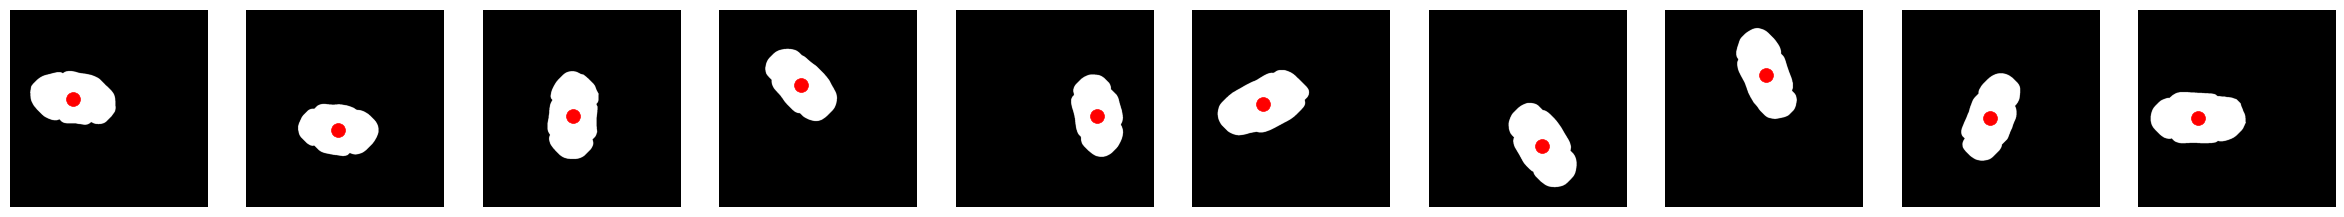

In [114]:
# calculate the center of mass of the mask
list_center_of_mass = []
for i, mask in enumerate(list_masks_dilated):
    center_of_mass = np.array([np.mean(np.where(mask > 0)[0]), np.mean(np.where(mask > 0)[1])])
    list_center_of_mass.append(center_of_mass)
# plotting list_rescaled_images as a single row and the center of mass as a red spot in the image
fig, axs = plt.subplots(1, number_files, figsize=(30, 10))
for i, masks in enumerate(list_masks_dilated):
    axs[i].imshow(masks,cmap='Greys_r')
    axs[i].scatter(list_center_of_mass[i][1], list_center_of_mass[i][0], c='r', s=100)
    axs[i].axis('off')

In [51]:
selected_cell = 2

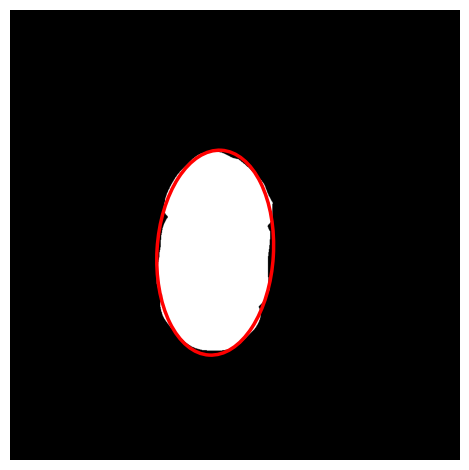

264.95281982421875 466.8224792480469 3.427560806274414


In [115]:
# Fitting an ellipse to the mask
image = list_masks_dilated[selected_cell]
# Find contours in the binary image
contours = cv2.findContours(image.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
# Assume the largest contour is the region of interest
cnt = max(contours, key=cv2.contourArea)
# Fit an ellipse to the contour
ellipse = cv2.fitEllipse(cnt)
# Extract ellipse parameters
(xc, yc), (d1, d2), angle = ellipse
# Create a figure and a set of subplots
fig, ax = plt.subplots()
# Display the image
ax.imshow(image, cmap='gray')
# Create an ellipse patch. The width and height are switched here to match the image coordinate system used by imshow
ellipse_patch = patches.Ellipse(xy= (xc, yc), width= d1, height= d2, angle=angle, edgecolor='r', facecolor='none', linewidth=2.5)
# Add the ellipse patch to the axes
ax.add_patch(ellipse_patch)
# Set plot limits and properties
ax.set_axis_off()
plt.tight_layout()
plt.show()
print(d1, d2, angle)


In [118]:
# Calculating the membrane mask
def compute_membrane_mask(mask):
    NUM_PIXELS_TO_DILATE = 1
    mask = mask.astype(np.int8)
    mask_neighbors = np.zeros_like(mask)
    for i in range(1, np.max(mask) + 1):
        mask_i = mask == i
        mask_i_dilated = binary_dilation(mask_i, iterations=NUM_PIXELS_TO_DILATE) 
        # Use XOR to find the difference between the dilated and original mask
        mask_i_neighbors = mask_i_dilated ^ mask_i
        # Only keep neighbor values that correspond to different labels in the original mask
        mask_i_neighbors = mask_i_neighbors * mask
        mask_neighbors += mask_i_neighbors
        mask_neighbors[mask_neighbors>0] = 1
        mask_neighbors_binary = binary_fill_holes(mask_neighbors.astype(np.int8))
    return mask_neighbors_binary

(-0.5, 1023.5, 1023.5, -0.5)

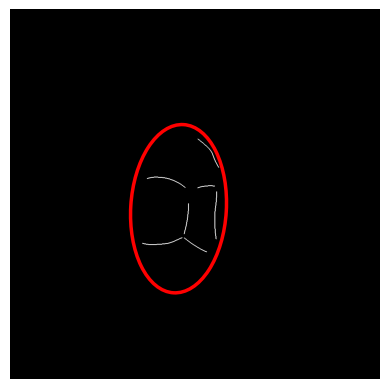

In [119]:
membrane_mask = compute_membrane_mask(list_masks[selected_cell])
# making all elements larger than one equal to one
fig, ax = plt.subplots()
ellipse_patch = patches.Ellipse(xy= (xc, yc), width= d1, height= d2, angle=angle, edgecolor='r', facecolor='none', linewidth=2.5)
ax.add_patch(ellipse_patch)
plt.imshow(membrane_mask,cmap='Greys_r')   
plt.axis('off')

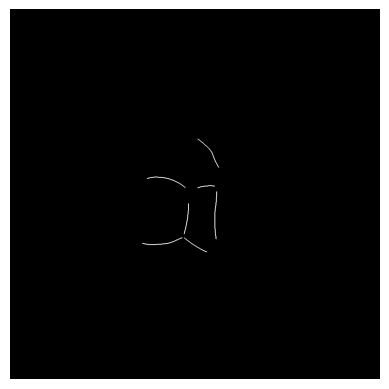

In [120]:
# Need a mask fo the membrane
membrane_mask = compute_membrane_mask(list_masks[selected_cell])
# making all elements larger than one equal to one
membrane_mask[membrane_mask>0] = 1
# plotting the membrane mask
fig, ax = plt.subplots()
ax.imshow(membrane_mask,cmap='Greys_r')
ax.axis('off')
plt.show()

In [55]:
# label cell based on cell characteristics

